In [1]:
# Imports
import torch
has_cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("wohlert") # add Wohlert's code: https://github.com/wohlert/semi-supervised-pytorch
print(f'cuda: {has_cuda}')

RANDOM_SEED=42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

cuda: False


In [2]:
gtex_filename = "../data/gtex_gene_small.tsv"

# NN structure
input_dim      = 18965 # gtex-gene features
latent_dim     = 32
hidden1_dim    = 128         
hidden2_dim    = 256         
hidden3_dim    = 1024

# Data loader
BATCH_SIZE     = 32
NUM_WORKERS    = 4
PRETECH_FACTOR = 2

# Training pars
TRAIN_EPOCHS   = 10  
LEARNING_RATE  = 1e-4 
BETA           = 1

# Variational Autoencoder

The variational autoencoder (VAE) was described in its current form in [Kingma 2013](https://arxiv.org/abs/1312.6114). The model consists of an encoder/inference network $q_{\phi}(z|x)$ and a decoder/generative network $p_{\theta}(x|z)$. The main idea is that it is possible to both reconstruct and generate samples from some input distribution by learning a variational distribution over the latent variable $z$.

<img src="wohlert/images/vae.png" width="300px"/>

The VAE therefore has a bottleneck structure, where the input $x$ is encoded into a latent variable $z$. New data can then be generated by feeding a latent code into the generator network - $\widehat{x} \sim p_{\theta}(z|x)$. The diagram above shows the generative model (right) and how the latent variable $z$ is inferred from $x$ (left).

Below a new variational autoencoder is instantiated with this bottleneck structure consisting of a 3-layer encoder network turning a GTEx-Gene sequence sample into a latent code: $18965 \to 1024 \to 256 \to 128 \to 32$. The decoder performs the operation in reverse.

In [3]:
from models import VariationalAutoencoder
from layers import GaussianSample
model = VariationalAutoencoder([input_dim, latent_dim, [hidden1_dim, hidden2_dim, hidden3_dim]])
model

/home/evs/own/Courses/0_DEEP/P/git_p/code/wohlert/models/vae.py:116: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


VariationalAutoencoder(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=18965, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=1024, bias=True)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=1024, out_features=32, bias=True)
      (log_var): Linear(in_features=1024, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=32, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
    )
    (reconstruction): Linear(in_features=128, out_features=18965, bias=True)
    (output_activation): Sigmoid()
  )
)

Notice how the middle most layer consists of a `GaussianSample` layer, in which we turn the input digit into the parameters of a Normal distribution with parameters $\mu$ and $\sigma$. This allows us to use the *reparametrization trick* to sample from this distribution to introduce stochasticity into the network.

In [4]:
from torch.autograd import Variable

gaussian = GaussianSample(10, 1)
z, mu, log_var = gaussian(Variable(torch.ones(1, 10)))

print(f"sample {float(z.data):.2f} drawn from N({float(mu.data):.2f}, {float(log_var.exp().data):.2f})")

sample -0.09 drawn from N(0.36, 3.43)


## Training

How do we go about training a variational autoencoder then? We want to model the data distribution $p(x)$, from here we can introduce a variational distribution $q(z|x)$ by multiplying and dividing by this distribution. Now we employ Jensen's inequality to move the logarithm inside the integral, we can do this because $\log$ is concave and because $q(z|x)$ is a probability distribution. From here on we just rearrange and we see that a lower bound on the marginal probability of the data $p(x)$ is just an expectation over the likelihood of the data minus the KL-divergence between the variational distribution and a prior $p(z)$.

\begin{align}
\log p(x) &= \log \int p(x, z) \ dz = \log \int q(z|x) \frac{p(x, z)}{q(z|x)} \ dz\\
          &\geq \int q(z|x) \log \frac{p(x, z)}{q(z|x)} \ dz = \int q(z|x) \log p(x|z) + \log \frac{p(z)}{q(z|x)} \ dz\\
          &= \int q(z|x) \log p(x|z) \ dz + \int q(z|x) \log \frac{p(z)}{q(z|x)} \ dz\\
          &= \mathbb{E}_{q(z|x)} [\log p(x|z)] - KL(q(z|x)||p(z)) = \mathcal{L}(x)
\end{align}

To make things even more concrete, we show how we can go from this equation to an actual algorithm. Recall that the expectation is just an arithmetic mean, which can be approximated using Monte-Carlo samples. In fact for most applications we can do with just a single sample, even though this provides infinite variance.

$$\mathbb{E}_{q(z|x)} [\log p(x|z)] = \lim_{N \to \infty} \frac{1}{N} \sum_{i=1}^{N} \log p(x_i|z_i) \approx \frac{1}{M} \sum_{i=1}^{M} \log p(x_i|z_i)$$

As you can see the likelihood is just the log probability of the data given the latent variable, but the latent variable is itself derived from the data - we can just use the reconstruction error! In the MNIST case, it is most fitting to use the Bernoulli / binary cross entropy.

Finally, the second term is the Kullback-Leibler divergence. It states that whatever distribution we learn over $q(z|x)$ can never be very far from the prior $p(z)$. This is both good and bad news. Ideally we want a reconstruction that is as good as possible, i.e. only relying on the likelihood, which will only occur if $q(z|x) = p(z)$. This will never happen in practice as the q-distribution will be very complex in order to produce latent variables that result convincing samples. On the plus side, the KL-term acts as a regularizer that pulls the distribution towards the prior, which is the whole reason why we can create samples.

This term can either be computed analytically, or by sampling similarly to the way we did it in the expectation, which you can see in the printed doc string below.

In [5]:
print(model._kld.__doc__)


        Computes the KL-divergence of
        some element z.

        KL(q||p) = -∫ q(z) log [ p(z) / q(z) ]
                 = -E[log p(z) - log q(z)]

        :param z: sample from q-distribuion
        :param q_param: (mu, log_var) of the q-distribution
        :param p_param: (mu, log_var) of the p-distribution
        :return: KL(q||p)
        


In [6]:
from data_loader import StreamDataLoader # import our StreamDataLoader
from torch.utils.data import DataLoader

train_stream = StreamDataLoader(filename=gtex_filename, batch_size=BATCH_SIZE, split="train", use_cuda=has_cuda)
val_stream   = StreamDataLoader(filename=gtex_filename, batch_size=BATCH_SIZE, split="val",   use_cuda=has_cuda)

train_dl     = DataLoader(train_stream, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, prefetch_factor=PRETECH_FACTOR)
val_dl       = DataLoader(val_stream,   batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, prefetch_factor=PRETECH_FACTOR)

# verify size of a sample batch
sample_batch = next(iter(train_dl))
for i, tensor in enumerate(sample_batch):
    print(f'Train: Tensor {i}: {tensor.size()}')
print(f'Total number of samples: {BATCH_SIZE*len(train_dl)}')

sample_batch = next(iter(val_dl))
for i, tensor in enumerate(sample_batch):
    print(f'Validation: Tensor {i}: {tensor.size()}')    
print(f'Total number of samples: {BATCH_SIZE*len(val_dl)}')    

Dataset loaded
Dataset loaded
Train: Tensor 0: torch.Size([32, 18965])
Train: Tensor 1: torch.Size([32, 0, 1])
Total number of samples: 800
Validation: Tensor 0: torch.Size([32, 18965])
Validation: Tensor 1: torch.Size([32, 0, 1])
Total number of samples: 224


In [7]:
# Loss function
def MSE(r, x):
    return torch.mean((r - x) ** 2)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))

In [8]:
train_loss_matrix = np.zeros([TRAIN_EPOCHS, len(train_dl)])
val_loss_matrix   = np.zeros([TRAIN_EPOCHS, len(val_dl)])
for epoch in range(TRAIN_EPOCHS):
    model.train()
    epoch_train_loss    = 0
    epoch_train_MSE     = 0
    epoch_train_KLdiv   = 0
    epoch_val_loss      = 0
    batch_counter       = 0
    
    # TRAINING LOOP
    for (u, _) in train_dl:
        u = u[:,:input_dim] # cap to input_dim features for quicker tests if needed
        u = Variable(u)

        if has_cuda: u = u.cuda(device=0)

        reconstruction = model(u)
        
        mse_loss = MSE(reconstruction, u)
        # ELBO is maximized in a VAE.
        # By inverting ELBO, the terms inside are in practice minimized:
        # minimizing mse_loss -> good sample reconstruction
        # minimizing KL_div   -> "moves" distribution of latent vars towards prior distributions (acting as a regularizer)
        elbo = -(mse_loss + BETA * torch.mean(model.kl_divergence))
        
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_loss = L.item()        
        epoch_train_loss += batch_loss

        # MSE and KL divergence (normalized by batch size)
        epoch_train_MSE   += mse_loss.item() * u.size(0)  
        epoch_train_KLdiv += BETA*torch.mean(model.kl_divergence).item() * u.size(0) 

        train_loss_matrix[epoch, batch_counter] = batch_loss
        batch_counter += 1        

    # MSE and KL divergence (normalized by total number of samples in epoch)
    epoch_train_MSE   /= len(train_dl.dataset)
    epoch_train_KLdiv /= len(train_dl.dataset)

    # VALIDATION LOOP
    batch_counter = 0
    model.eval()    
    with torch.inference_mode():                
        for (u, _) in val_dl:
            u = u[:,:input_dim]
            u = Variable(u)

            if has_cuda: u = u.cuda(device=0)

            reconstruction = model(u)
            mse_loss = MSE(reconstruction, u)
            elbo = -(mse_loss + BETA * torch.mean(model.kl_divergence))

            batch_loss = -torch.mean(elbo).item()
            epoch_val_loss += batch_loss
            val_loss_matrix[epoch, batch_counter] = batch_loss
            batch_counter += 1        

    # Naive overfit detection
    overfit_warning_str = ''
    if (epoch >= 2):
        if (sum(val_loss_matrix[epoch,:]) > sum(val_loss_matrix[epoch-1,:])) and \
           (sum(val_loss_matrix[epoch-2,:]) > sum(val_loss_matrix[epoch-1,:])):
            overfit_warning_str = ' <--- Possible overfit'

    print(f'Epoch: {epoch}\ttrain loss: {epoch_train_loss/len(train_dl):2.2f}\tval loss: {epoch_val_loss/len(val_dl):2.2f}{overfit_warning_str}')    
    print(f'                train MSE: {epoch_train_MSE/len(train_dl):2.2f}\t\ttrain KLdiv: {epoch_train_KLdiv/len(train_dl):2.2f}\n')


print(np.round(np.mean(train_loss_matrix, axis=1),2))
print(np.round(np.mean(val_loss_matrix, axis=1),2))

Epoch: 0	train loss: 23.78	val loss: 14.72
                train MSE: 0.50		train KLdiv: 0.45

Epoch: 1	train loss: 12.26	val loss: 9.98
                train MSE: 0.44		train KLdiv: 0.05

Epoch: 2	train loss: 6.99	val loss: 4.14
                train MSE: 0.26		train KLdiv: 0.02

Epoch: 3	train loss: 3.00	val loss: 2.41
                train MSE: 0.10		train KLdiv: 0.02

Epoch: 4	train loss: 2.11	val loss: 2.20
                train MSE: 0.07		train KLdiv: 0.02

Epoch: 5	train loss: 1.92	val loss: 1.85
                train MSE: 0.06		train KLdiv: 0.02

Epoch: 6	train loss: 1.80	val loss: 1.81
                train MSE: 0.06		train KLdiv: 0.01

Epoch: 7	train loss: 1.75	val loss: 1.92 <--- Possible overfit
                train MSE: 0.06		train KLdiv: 0.01

Epoch: 8	train loss: 1.89	val loss: 1.76
                train MSE: 0.06		train KLdiv: 0.02

Epoch: 9	train loss: 1.86	val loss: 1.76 <--- Possible overfit
                train MSE: 0.06		train KLdiv: 0.02

[23.78 12.26  6.99  3. 

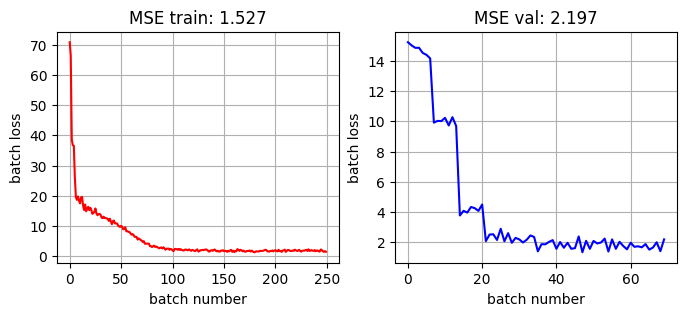

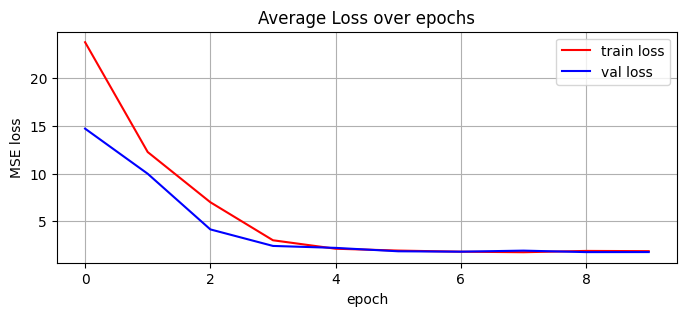

In [9]:
if True: 
 # concatenate recorded batch losses for each epoch
 train_loss_vector = train_loss_matrix.reshape(TRAIN_EPOCHS*len(train_dl),1).squeeze()
 val_loss_vector   = val_loss_matrix.reshape(TRAIN_EPOCHS*len(val_dl),1).squeeze()

 fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))

 ax1.plot(train_loss_vector, 'r')  
 ax1.set_xlabel('batch number')
 ax1.set_ylabel('batch loss') 
 ax1.set_title(f'MSE train: {train_loss_vector[-1]:2.3f}')
 ax1.grid('both')

 ax2.plot(val_loss_vector, 'b')  
 ax2.set_xlabel('batch number')
 ax2.set_ylabel('batch loss') 
 ax2.set_title(f'MSE val: {val_loss_vector[-1]:2.3f}')
 ax2.grid('both')

 plt.show()
 

if True:
 plt.figure(figsize=(8,3))
 plt.plot(np.mean(train_loss_matrix, axis=1), 'r', label='train loss')
 plt.plot(np.mean(val_loss_matrix, axis=1), 'b', label='val loss')  
 plt.title('Average Loss over epochs')
 plt.xlabel('epoch')
 plt.ylabel('MSE loss')
 plt.grid('both')
 plt.legend()


## Sampling from the generative model

Now that we have trained the network, we can begin to sample from it. We simply give it some random noise distributed according to the prior $p(z) = \mathcal{N}(0, I)$ and send it through the decoder. This process generates a slew of samples that look like they come from the original distribution $p(x)$.

In [10]:
n_samples = 128
model.eval()
x_mu = model.sample(Variable(torch.randn(n_samples, latent_dim)))

x_mu_np = x_mu.detach().cpu().numpy()

## PCA analysis:
- Make a PCA on the training data and transform it.
- Transform the generated data with the found pca's above.
- Plot both transformed data sets to assess whether they are in similar regions.

`IncrementalPCA` is used to perform the PCA in batches (due to memory limitations).

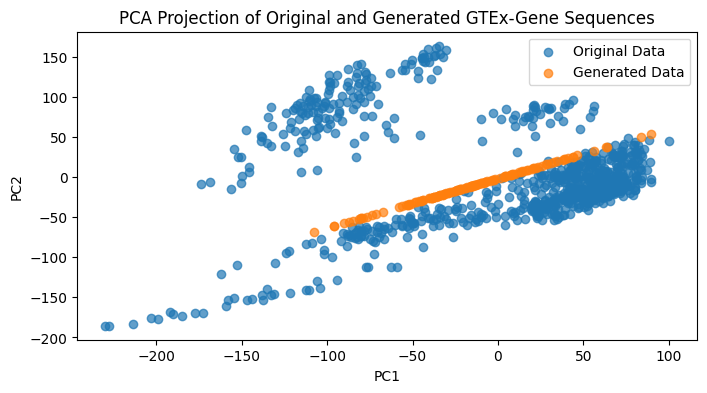

In [11]:
from sklearn.decomposition import IncrementalPCA
import numpy as np
import matplotlib.pyplot as plt

# Incremental PCA
n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=BATCH_SIZE)

# Fit IPCA on training data
for data, _ in train_dl:
    ipca.partial_fit(data.cpu().numpy())

# Transform generated data
generated_data_transformed = ipca.transform(x_mu_np)

# Transform original data (in batches)
def transform_in_batches(dataloader, pca_model):
    transformed_data_list = []
    for data, _ in dataloader:
        transformed_batch = pca_model.transform(data.cpu().numpy())
        transformed_data_list.append(transformed_batch)
    return np.concatenate(transformed_data_list, axis=0)

original_data_transformed = transform_in_batches(train_dl, ipca)

# Visualization
plt.figure(figsize=(8, 4))

# Plot original data
plt.scatter(original_data_transformed[:, 0], original_data_transformed[:, 1], alpha=0.7, label='Original Data')

# Plot generated data
plt.scatter(generated_data_transformed[:, 0], generated_data_transformed[:, 1], alpha=0.7, label='Generated Data')

plt.title('PCA Projection of Original and Generated GTEx-Gene Sequences')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()
